##### Automatische verbetering
**Dit labo wordt automatisch verbeterd! Let dus goed op dat alle tests die in de notebook staan slagen. Er zijn nog heel wat extra tests die de correctheid van jullie code zullen controleren. Deze tests zitten niet in deze notebook, maar worden uitgevoerd door de verbetersoftware.**

**BELANGRIJK: Maak het practicum <span style='color:red'>NIET</span> in Visual Studio, Visual Studio Code, of andere Microsoft brolware. Installeer gewoon jupyter, en start het zelf op (in de terminal: `jupyter notebook .` of eventueel `python3 -m notebook .`) zodat alles op jouw eigen computer draait.**


# Benodigdheden

Voor dit labo heb je 3 packages nodig: `numpy`, `imageio`, `matplotlib`, en `jupyter`.
Installeren kan je doen met `pip3 install <package>`. Wanneer je Anaconda gebruikt zouden deze packages reeds geinstalleerd moeten zijn. Wanneer je Miniconda gebruikt moet je ze mogelijk zelf nog installeren: start de Miniconda/Anaconda Prompt, en installeer ze met `conda install <package>` (in jouw environment naar keuze, vergeet dus niet jouw environment niet te activeren). Voor de mensen die zonder conda werken, installeren doe je zoals gebruikelijk met `pip install <package>`.

# Richtlijnen
Probeer steeds gebruik te maken van numpy. Python `for`-loop zijn te vermijden wanneer het enige doel van de loop is om over de data te itereren.

<hr />

In [2]:
import math

import numpy as np
from IPython.display import Image, display
import imageio
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

import os

os.makedirs("output/", exist_ok=True)

def dispim(fn, data, width=400):
    fn = "output/" + fn
    if data.dtype == np.uint16:
        data = (data / 2 ** 8).astype(np.uint8)
    elif data.dtype == np.float64 or data.dtype == np.float32:
        assert np.amin(data) >= 0.0
        assert np.amax(data) <= 1.0
        assert not np.isnan(data).any()
        data = (data * (2 ** 8 - 1)).astype(np.uint8)
    imageio.imwrite(fn, data, quality=95)
    display(Image(filename=fn, width=width))

# 1. CIE ColorSpaces
## 1.1. CIE XYZ 1931 zoals benaderd door NVIDIA
NVIDIA heeft computationeel eenvoudige *benaderingen* opgesteld voor de CIE XYZ reactiefuncties. Deze vindt je hieronder, geïmplementeerd in numpy:

In [3]:
def xFit_1931(wave):
    t1 = (wave - 442.0) * np.where(wave < 442.0, 0.0624, 0.0374)
    t2 = (wave - 599.8) * np.where(wave < 599.8, 0.0264, 0.0323)
    t3 = (wave - 501.1) * np.where(wave < 501.1, 0.0490, 0.0382)
    return 0.362 * np.exp(-0.5 * t1 * t1) + \
           1.056 * np.exp(-0.5 * t2 * t2) - \
           0.065 * np.exp(-0.5 * t3 * t3)

def yFit_1931(wave):
    t1 = (wave - 568.8) * np.where(wave < 568.8, 0.0213, 0.0247)
    t2 = (wave - 530.9) * np.where(wave < 530.9, 0.0613, 0.0322)
    return 0.821 * np.exp(-0.5 * t1 * t1) + 0.286 * np.exp(-0.5 * t2 * t2)

def zFit_1931(wave):
    t1 = (wave - 437.0) * np.where(wave < 437.0, 0.0845, 0.0278)
    t2 = (wave - 459.0) * np.where(wave < 459.0, 0.0385, 0.0725)
    return 1.217 * np.exp(-0.5 * t1 * t1) + 0.681 * np.exp(-0.5 * t2 * t2)

We zullen deze functies bekijken voor golflengtes tussen 380nm en 720nm. Hiervoor stellen we volgende hulpvariabele `nv_nms` (kort voor 'NVIDIA nanometers') en hulpfunctie `plot_curves` voor op.

In [4]:
nv_nms = np.arange(380, 720) # 340 stappen
print("Aantal golflengtes:", len(nv_nms))

def plot_curves(x, data, labels, colors=None, label_prefix=None, linestyle='-'):
    for i in range(len(data)):
        l = labels[i]
        if label_prefix is not None:
            l = label_prefix + " " + l
        plt.plot(x, data[i], label=l, color=None if colors is None else colors[i], linestyle=linestyle)

Aantal golflengtes: 340


Maak de numpy array die de data van de drie curves bevat, en noem deze `nv_XYZ_curves`. Deze moet een 3 x 340 matrix zijn, aangezien we 3 curves hebben, en we deze evalueren op 340 verschillende golflengtes. **Hint** Dit kan zonder for-loops, aangezien de functies die de NVIDIA fit implementeren werken op numpy arrays (zoals `nms`).

In [5]:
# YOUR CODE HERE
nv_XYZ_curves = np.array([xFit_1931(nv_nms), yFit_1931(nv_nms), zFit_1931(nv_nms)])

In [6]:
assert type(nv_XYZ_curves) is np.ndarray
# XYZ_curves moet een 3 bij 340 arrray zijn:
assert nv_XYZ_curves.shape == (3, 340)
# De integralen van de X, Y, en Z functies moeten gelijk zijn:
assert np.std(np.mean(nv_XYZ_curves, 1)) < 0.0005
# Y curve heeft maximale waarde 1:
assert np.isclose(np.max(nv_XYZ_curves[1]), 1.0, atol=0.02)

Volgende code zal de XYZ curves plotten, als je de opdracht juist hebt uitgevoerd:

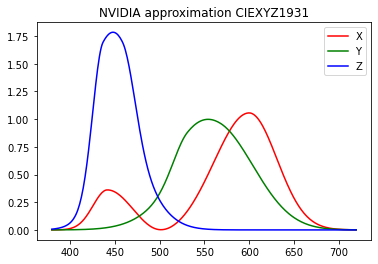

In [7]:
plot_curves(nv_nms, nv_XYZ_curves, labels='XYZ', colors='rgb')
plt.title("NVIDIA approximation CIEXYZ1931")
plt.legend()
plt.show()

### 1.1.1. NVIDIA xy-chromaticiteitsdiagram
Maak een plot van het xy-diagram door de X, Y, Z waarden te projecteren naar het xy-vlak (X+Y+Z=1), voor elk van de 340 golflengten. Gebruik dus de NVIDIA XYZ curves. Noem de resulterende coördinaten `nv_xy_curve` (for-loops zijn niet toegestaan, gebruik numpy). Controleer dat je de vorm van de horseshoe uitkomt.

In [8]:
# YOUR CODE HERE
nv_xy_curve = np.array([nv_XYZ_curves[0]/(nv_XYZ_curves[1] + nv_XYZ_curves[2] + nv_XYZ_curves[0]), nv_XYZ_curves[1]/(nv_XYZ_curves[1] + nv_XYZ_curves[2] + nv_XYZ_curves[0])])

In [9]:
def draw_spectral_locus(nms, xy_curve, title="", text_step=5, show=True):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.plot(xy_curve[0], xy_curve[1])
    plt.scatter(xy_curve[0,::text_step], xy_curve[1,::text_step], s=9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    for nm, xy in list(zip(nms, xy_curve.T))[::text_step]:
        ax.text(xy[0], xy[1] + 0.01, str(nm) + "nm", fontsize=8.5)
    plt.title("Chromaticity diagram " + title)
    plt.tight_layout()
    if show:
        plt.show()

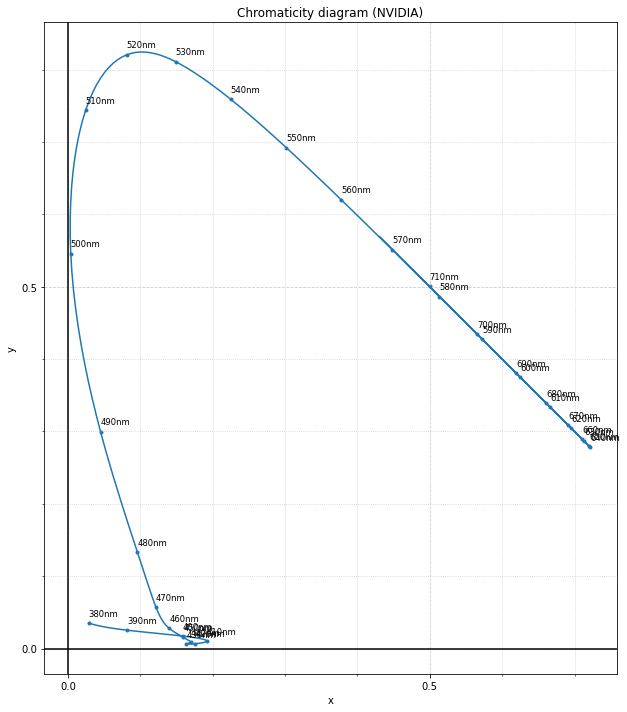

In [10]:
draw_spectral_locus(nv_nms, nv_xy_curve, title="(NVIDIA)", text_step=10)

Als alles goed ging, zie je de horseshoe, met een klein "staartje". Hoe kan je dit staartje verklaren?

 - **Optie A**: De range aan golflengtes die in rekening worden gebracht is te groot.
 - **Optie B**: Bij de online figuren wordt dit staartje altijd weggelaten.
 - **Optie C**: Het staartje is het resultaat van inaccurate XYZ curves.
 
Welke optie is het juiste antwoord? Vul de Python-string `"A"`, `"B"`, of `"C"` in in de variabele `antwoord_staartje`.

In [1]:
# YOUR CODE HERE
antwoord_staartje = "C"

In [12]:
assert type(antwoord_staartje) is str, "Must by a Python string"
assert antwoord_staartje in ["A", "B", "C"], "Must be either A, B, or C."

## 1.2. CIEXYZ 1931

Om maximale accuraatheid in de berekeningen te bekomen, zullen we gebruik maken van tabulaire data, zoals vastgelegd door CIE in 1931. Deze data is een herwerking van de data van Wright en Guild, met kleine aanpassingen. Zo werd onder meer de Equal Energy illuminant gebruikt om de experimenten mee te normaliseren, in plaats van de NLP Standard White, zoals effectief gebruikt tijdens het experiment.

Hieronder laden we de gestandardiseerde data van CIEXYZ1931 in. Dit zijn de XYZ color matching functions.

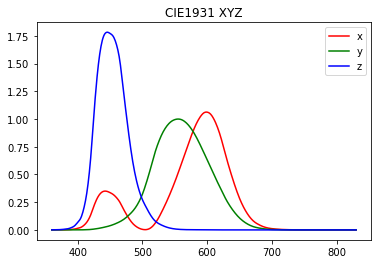

In [13]:
cie_data = np.loadtxt("ciexyz31_1.csv", delimiter=',')
cie_nms = cie_data[:,0].T
cie_XYZ_curves = cie_data[:,1:].T
plot_curves(cie_nms, cie_XYZ_curves, labels='xyz', colors='rgb')
plt.title("CIE1931 XYZ")
plt.legend()
plt.show()

### 1.2.1. CIE xy-chromaticiteitsdiagram
Maak een plot van het xy-diagram door de X, Y, Z waarden te projecteren naar het xy-vlak (X+Y+Z=1), voor elk van de golflengten. Gebruik dus de CIE XYZ curves. Noem de resulterende coördinaten `cie_xy_curve` (for-loops zijn niet toegestaan, gebruik numpy). Controleer dat je de vorm van de horseshoe uitkomt.

In [14]:
# YOUR CODE HERE
cie_xy_curve = np.array([cie_XYZ_curves[0]/(cie_XYZ_curves[1] + cie_XYZ_curves[2] + cie_XYZ_curves[0]), cie_XYZ_curves[1]/(cie_XYZ_curves[1] + cie_XYZ_curves[2] + cie_XYZ_curves[0])])

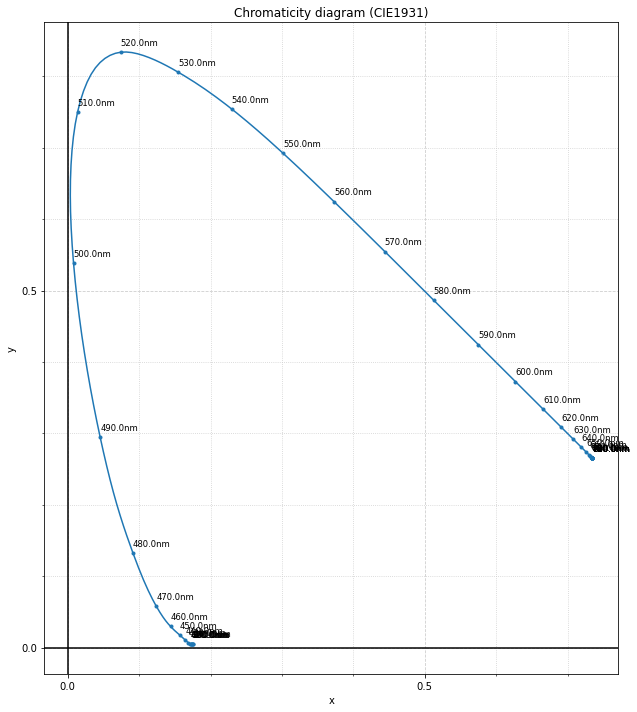

In [15]:
draw_spectral_locus(cie_nms, cie_xy_curve, title="(CIE1931)", text_step=10)

## 1.3 Judd-Vos XYZ 1978
Judd paste in 1951 de XYZ functies aan, dewelke Vos in 1978 opnieuw verbeterde. Deze tabulaire data wordt hieronder ingeladen.

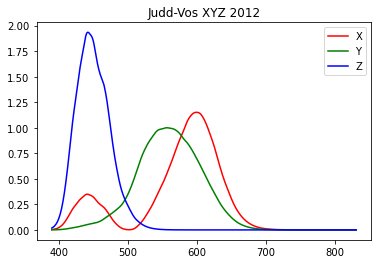

In [16]:
judd_vos = np.loadtxt("lin2012xyz2e_1_7sf.csv", delimiter=',')
jv_nms = judd_vos[:,0].T
jv_XYZ_curves = judd_vos[:,1:].T

plot_curves(jv_nms, jv_XYZ_curves, labels='XYZ', colors='rgb')
plt.title("Judd-Vos XYZ 2012")
plt.legend()
plt.show()

### 1.3.1 Judd-Vos xy-chromaticiteitsdiagram
Produceer de xy-curves zoals voordien, maar met de Judd-Vos data, en stop in `jv_xy_curve`.

In [17]:
# YOUR CODE HERE
jv_xy_curve = np.array([jv_XYZ_curves[0]/(jv_XYZ_curves[1] + jv_XYZ_curves[2] + jv_XYZ_curves[0]), jv_XYZ_curves[1]/(jv_XYZ_curves[1] + jv_XYZ_curves[2] + jv_XYZ_curves[0])])

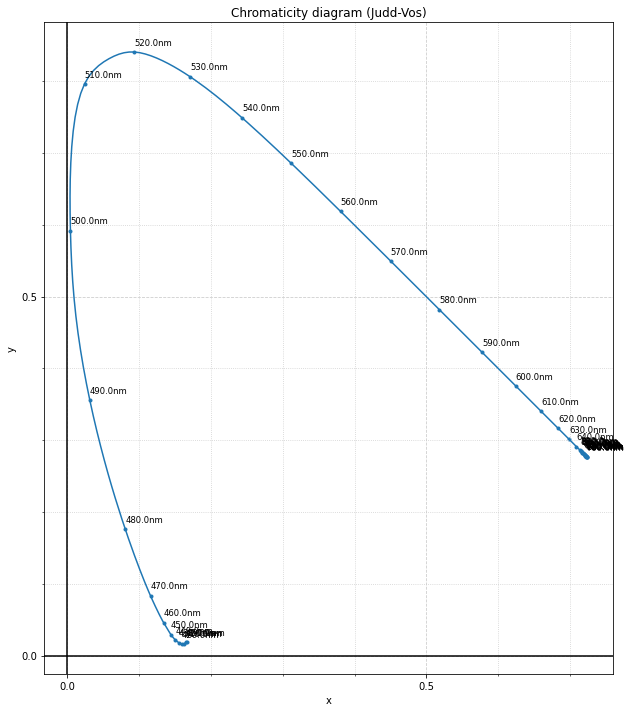

In [18]:
draw_spectral_locus(jv_nms, jv_xy_curve, title="(Judd-Vos)", text_step=10)

## 1.4. CIERGB
Als eerste zullen we ongeveer de CIE RGB curves reconstrueren (wat dus de andere volgorde is als dit vergelijkt met de geschiedenis: daar is eerst de CIE RGB ruimte gemaakt, waaruit de CIE XYZ ruimte is afgeleid. Hier doen we het andersom, aangezien de standaard CIEXYZ enkele wijzigingen maakte ten opzichte van Wright-Guild RGB data). Zoek de transformatiematrix $M$ van CIE RGB naar CIE XYZ (op internet bijvoorbeeld; je hoeft deze niet uit te rekenen):

$$\begin{bmatrix}X \\ Y \\ Z \end{bmatrix} = M \begin{bmatrix}R \\ G \\ B \end{bmatrix} $$

Noem de matrix $M$ in jullie code `CIERGB_to_CIEXYZ`, en zorg ervoor dat dit een 2D numpy-array is.

In [19]:
# YOUR CODE HERE
CIERGB_to_CIEXYZ = np.array([[0.4887180, 0.3106803, 0.2006017],
                             [0.1762044, 0.8129847, 0.0108109],
                             [0.0000000, 0.0102048, 0.9897952]])
print("CIERGB to CIEXYZ:")
print(CIERGB_to_CIEXYZ)
print("Sum of rows", np.dot(CIERGB_to_CIEXYZ, [1, 1, 1]))
print("Det", np.linalg.det(CIERGB_to_CIEXYZ))

CIERGB to CIEXYZ:
[[0.488718  0.3106803 0.2006017]
 [0.1762044 0.8129847 0.0108109]
 [0.        0.0102048 0.9897952]]
Sum of rows [1. 1. 1.]
Det 0.33938788197599995


In [20]:
assert type(CIERGB_to_CIEXYZ) is np.ndarray
assert CIERGB_to_CIEXYZ.shape == (3,3)
assert np.isclose(np.linalg.det(CIERGB_to_CIEXYZ), 0.34, atol=0.01)
assert np.isclose(np.dot(CIERGB_to_CIEXYZ, [1, 1, 1]), [1, 1, 1]).all() # Equal energy balanced

Gebruik de `CIERGB_to_CIEXYZ` om de CIERGB curves te reconstrueren (voor dezelfde golflengte-range als voordien (`cie_nms`)). Construeer dus de 3 x 471 numpy array met de CIERGB curves in, en noem deze `cie_RGB_curves`.

In [21]:
# YOUR CODE HERE
cie_RGB_curves = np.dot(np.linalg.inv(CIERGB_to_CIEXYZ), cie_XYZ_curves)

In [22]:
assert type(cie_RGB_curves) is np.ndarray
# RGB_curves moet een 3 bij 471 arrray zijn:
assert cie_RGB_curves.shape == (3, 471)

In [23]:
# Deze cell bevat tests, laat staan.

We bekijken nu de CIE RGB curves:

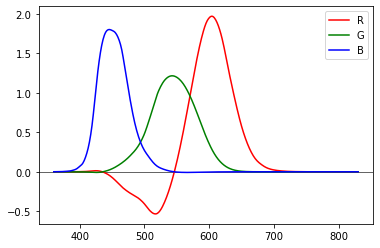

In [24]:
plt.figure()
plt.axhline(y=0, color='k', linewidth=0.6)
plot_curves(cie_nms, cie_RGB_curves, 'RGB', 'rgb')
plt.legend()
plt.show()

Deze zouden jullie moeten herkennen uit de les! Of herkennen als je zoekt naar Wright-Guild RGB.

## 1.5. Vergelijking tussen NVIDIA, CIE1931, en Judd-Vos.

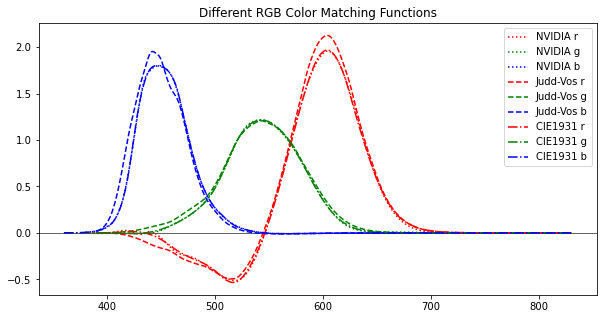

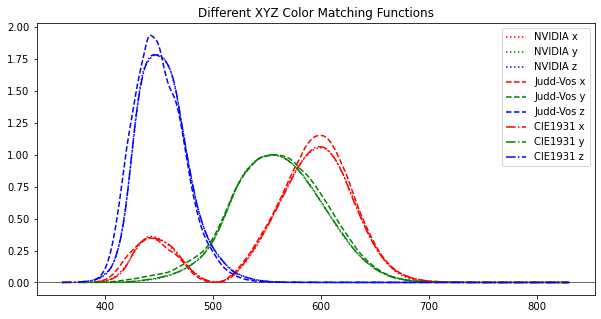

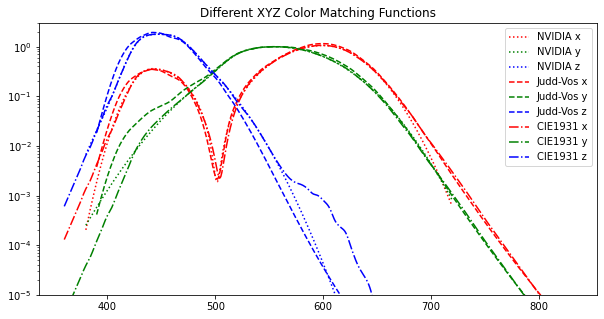

In [25]:
plt.figure(figsize=(10, 5))
plt.axhline(y=0, color='k', linewidth=0.6)
plot_curves(nv_nms , np.linalg.inv(CIERGB_to_CIEXYZ) @ nv_XYZ_curves , 'rgb', 'rgb', label_prefix='NVIDIA', linestyle=':')
plot_curves(jv_nms , np.linalg.inv(CIERGB_to_CIEXYZ) @ jv_XYZ_curves , 'rgb', 'rgb', label_prefix='Judd-Vos', linestyle='--')
plot_curves(cie_nms, np.linalg.inv(CIERGB_to_CIEXYZ) @ cie_XYZ_curves, 'rgb', 'rgb', label_prefix='CIE1931', linestyle='-.')
plt.title("Different RGB Color Matching Functions")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.axhline(y=0, color='k', linewidth=0.6)
plot_curves(nv_nms , nv_XYZ_curves ,'xyz', 'rgb', label_prefix='NVIDIA', linestyle=':')
plot_curves(jv_nms , jv_XYZ_curves ,'xyz', 'rgb', label_prefix='Judd-Vos', linestyle='--')
plot_curves(cie_nms, cie_XYZ_curves,'xyz', 'rgb', label_prefix='CIE1931', linestyle='-.')
plt.title("Different XYZ Color Matching Functions")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.axhline(y=0, color='k', linewidth=0.6)
plot_curves(nv_nms, nv_XYZ_curves, 'xyz', 'rgb', label_prefix='NVIDIA', linestyle=':')
plot_curves(jv_nms, jv_XYZ_curves, 'xyz', 'rgb', label_prefix='Judd-Vos', linestyle='--')
plot_curves(cie_nms, cie_XYZ_curves, 'xyz', 'rgb', label_prefix='CIE1931', linestyle='-.')
plt.title("Different XYZ Color Matching Functions")
plt.yscale("log")
plt.ylim(0.00001, 3.0)
plt.legend()
plt.show()

## 1.6. rg-chromaticiteitsdiagram
Herhaal nu, net zoals hierboven, de projectie van CIERGB naar CIE rg. Noem de resulterende rg-waarden `cie_rg_curve`.

In [26]:
# YOUR CODE HERE
cie_rg_curve = np.array([cie_RGB_curves[0]/(cie_RGB_curves[1] + cie_RGB_curves[2] + cie_RGB_curves[0]), cie_RGB_curves[1]/(cie_RGB_curves[1] + cie_RGB_curves[2] + cie_RGB_curves[0])])

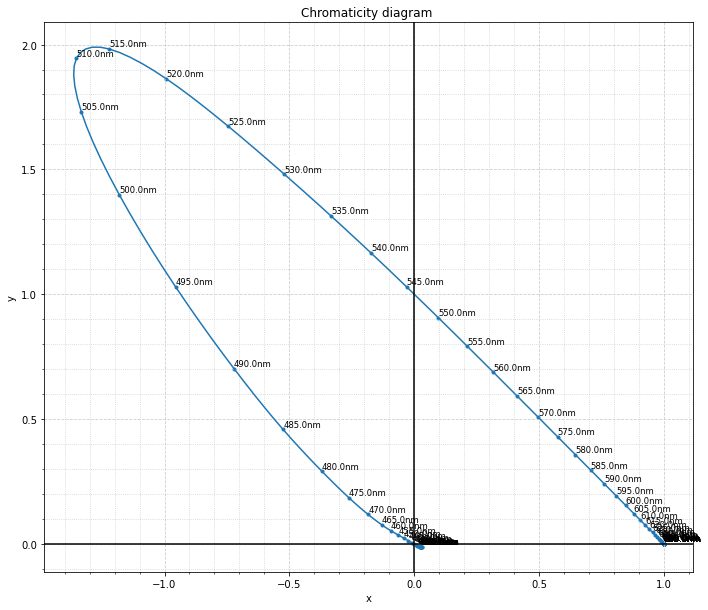

In [27]:
assert type(cie_rg_curve) is np.ndarray
assert cie_rg_curve.shape == (2, 471)

draw_spectral_locus(cie_nms, cie_rg_curve)

## 1.7. xy-chromaticiteitsdiagram met de CIERGB primairen.

Hier zullen we nogmaals het xy-diagram maken, maar de CIERGB primairen voorstellen met een driehoek waarvan de hoekpunten de chromaticiteitscoördinaten zijn van deze primairen. Eens je deze coördinaten hebt berekend kan je ze plotten als driehoek met de hulpfunctie `plot_triangle()`.

In [28]:
# YOUR CODE HERE
RGB_primaries_in_xy = np.array([[0, 0, 255], [255, 0, 0], [0, 255, 0]])
RGB_primaries_in_xy = np.dot(CIERGB_to_CIEXYZ, RGB_primaries_in_xy)
RGB_primaries_in_xy = np.transpose(np.array([RGB_primaries_in_xy[0]/(RGB_primaries_in_xy[1] + RGB_primaries_in_xy[2] + RGB_primaries_in_xy[0]), RGB_primaries_in_xy[1]/(RGB_primaries_in_xy[1] + RGB_primaries_in_xy[2] + RGB_primaries_in_xy[0])]))
print(RGB_primaries_in_xy)

[[0.27399998 0.71700005]
 [0.167      0.00900002]
 [0.73500005 0.26499995]]


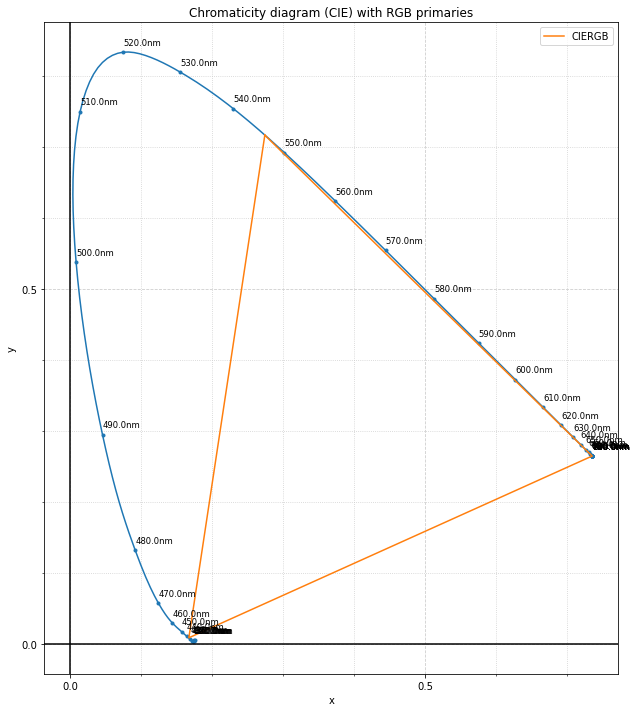

In [29]:
assert type(RGB_primaries_in_xy) is np.ndarray
assert RGB_primaries_in_xy.shape == (3, 2)

def plot_triangle(c0, c1, c2, **kwargs):
    coords = np.array([c0, c1, c2, c0])
    plt.plot(coords[:,0], coords[:,1], **kwargs)

draw_spectral_locus(cie_nms, cie_xy_curve, title="(CIE) with RGB primaries", text_step=10, show=False)
plot_triangle(RGB_primaries_in_xy[0], RGB_primaries_in_xy[1], RGB_primaries_in_xy[2], label='CIERGB')
plt.legend()
plt.show()

## 1.8. Hunt-Pointer-Estevez (Cone Domain)

We zullen nu ook de Hunt-Pointer-Estevez transformatie gebruiken om de LMS response functies af te leiden. Vul de matrix in in de variabele `HPE`, zodat:
$$\begin{bmatrix}L \\ M \\ S \end{bmatrix} = \text{HPE} \begin{bmatrix}X \\ Y \\ Z \end{bmatrix} $$
Gebruik de transformatie die gebalanceerd is voor de E-illuminant (i.e.: equal-energy illuminent). Gebalanceerd wil zeggen dat wanneer je de XYZ-coördinaat van de E-illuminant transformeert naar LMS met de HPE matrix dat je de vector (1, 1, 1) bekomt.

In [30]:
# YOUR CODE HERE
HPE = np.array([[0.38971, 0.68898, -0.07868],
                [-0.22981, 1.18340, 0.04641],
                [0.0, 0.0, 1.0]])
print(HPE)
print(np.dot(HPE, [1, 1, 1]))

[[ 0.38971  0.68898 -0.07868]
 [-0.22981  1.1834   0.04641]
 [ 0.       0.       1.     ]]
[1.00001 1.      1.     ]


In [31]:
assert HPE.shape == (3,3)
assert type(HPE) is np.ndarray
assert np.isclose(np.dot(HPE, [1, 1, 1]), [1, 1, 1]).all(), "Not E-illuminant balanced"

Gebruik de `HPE` om de LMS curves te reconstrueren uit de CIEXYZ curves (voor dezelfde golflengte-range als voordien (`cie_nms`)). Construeer dus de 3 x 471 numpy array met de LMS curves in, en noem deze `LMS_curves`.

In [32]:
# YOUR CODE HERE
LMS_curves = np.dot(HPE, cie_XYZ_curves)

In [33]:
assert LMS_curves.shape == (3, 471)

We bekijken nu de LMS curves:

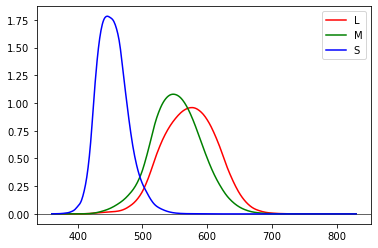

In [34]:
plt.figure()
plt.axhline(y=0, color='k', linewidth=0.6)
plot_curves(cie_nms, LMS_curves, 'LMS', 'rgb')
plt.legend()
plt.show()

## 1.9. Planckian Locus

De "Planckian Locus" is de verzameling van kleuren als gevolg van het verhitten van een zwarte straler (black-body radiator). Deze kleuren zullen we nu reconstrueren op het xy-chromaticiteitsdiagram.

### 1.9.1. Wet van Planck

Implementeer in de functie `black_body_radiator_spd` de wet van Planck die de SPD (spectral power distribution) voor een black body radiator op een gegeven temperatuur implementeert.
Zorg er voor dat de functie evalueerbaar is over meerdere golflengtes tegelijk. Zorg er voor dat de golflengte parameter (`wavelength`) wordt uitgedrukt in nanometer. Gebruik de "*spectral radiant exitance*" variant van de formule (deze is een factor $\pi$ groter).

In [35]:
speed_of_light = 299792458.0
planck_constant = 6.62607015e-34
boltzman_constant = 1.380649e-23

def black_body_radiator_spd(wavelength, temperature):
    wavelength = wavelength*(10**(-9))
    return np.pi * ((2*planck_constant*speed_of_light*speed_of_light)/(wavelength**5)) * (1/((np.exp((planck_constant*speed_of_light)/(wavelength*boltzman_constant*temperature))) - 1))

In [36]:
assert np.shape(black_body_radiator_spd(cie_nms, 1000.0)) == np.shape(cie_nms)
print(np.amax(black_body_radiator_spd(np.arange(10, 1000.0), 9000.0)))
assert np.isclose(np.amax(black_body_radiator_spd(np.arange(10, 1000.0), 9000.0)), 7.9e14, rtol=0.05) 

759780015692597.6


We plotten nu de SPD van een zwarte straler met temperatuur 3000 Kelvin, samen met (herschaalde) XYZ response curves.

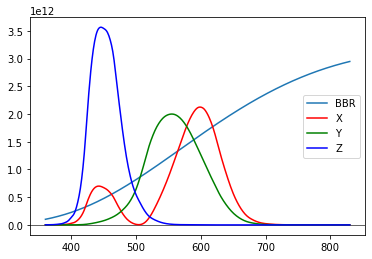

In [37]:
plt.figure()
plt.axhline(y=0, color='k', linewidth=0.6)
plt.plot(cie_nms, black_body_radiator_spd(cie_nms, 3000.0), label='BBR')
plot_curves(cie_nms, 2e12 * cie_XYZ_curves, 'XYZ', 'rgb')
plt.legend()
plt.show()

We plotten nu voor enkele temperaturen (1000K tot 9000K) de resulterende SPDs, met daarbij de XYZ response curves; voor 50nm tot 1000nm.

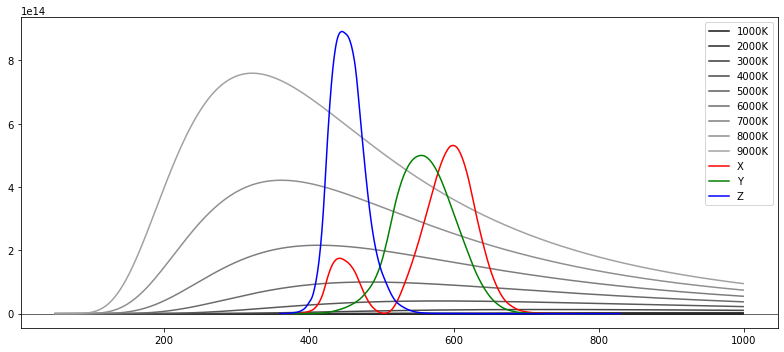

In [38]:
bbr_nms = np.arange(50.0, 1000.0)
plt.figure(figsize=(11, 5))
plt.axhline(y=0, color='k', linewidth=0.6)
for i in range(1, 10):
    K = 1000 * i
    plt.plot(bbr_nms, black_body_radiator_spd(bbr_nms, K),
             label='%dK' % K, color=str(i * 0.07))
plot_curves(cie_nms, 5e14 * cie_XYZ_curves, 'XYZ', 'rgb')
plt.legend()
plt.tight_layout()
plt.show()

### 1.9.2. Zwarte Stralers en tristimulus berekening door integratie.

Implementeer in de functie `black_body_radiator_xy` de functionaliteit die de xy-chromaticiteit berekent. Dit gebeurt door eerst de XYZ-tristimulus coëfficienten te berekenen. Dit doe je als volgt:

 1. Vermenigvuldig de XYZ functies met de SPD.
 2. Integreer dit resultaat om de totale reactie van de X, Y, en Z kegeltjes te bekomen. Dit is de tristimulus.
 3. Projecteer deze XYZ-coördinaat naar het X+Y+Z=1 vlak, voorgesteld met de xy-chromaticiteitscoördinaten.
 
(Aangezien alles discreet is in plaats van continu, is de integraal dus hier een som).

In [39]:
def black_body_radiator_xy(temperature):
    a = np.dot(cie_XYZ_curves, black_body_radiator_spd(cie_nms, temperature))
    return np.array([a[0]/(a[1] + a[2] + a[0]), a[1]/(a[1] + a[2] + a[0])])

print("Planckian Locus for some temperatures T:")
for T in [1000, 2000, 3000, 4000, 5000, 6000, 6500, 8000, 10000]:
    print("T= %5dK    xy=%s" % (T, str(black_body_radiator_xy(T))))

Planckian Locus for some temperatures T:
T=  1000K    xy=[0.6527507  0.34446166]
T=  2000K    xy=[0.52667749 0.413297  ]
T=  3000K    xy=[0.43693105 0.40407397]
T=  4000K    xy=[0.38043953 0.37674682]
T=  5000K    xy=[0.34510117 0.35160804]
T=  6000K    xy=[0.32208322 0.33175338]
T=  6500K    xy=[0.31352588 0.3236283 ]
T=  8000K    xy=[0.29518703 0.30476521]
T= 10000K    xy=[0.28063357 0.28828784]


In [40]:
assert np.shape(black_body_radiator_xy(1000.0)) == (2,)
assert np.isclose(black_body_radiator_xy(6500.0), [0.3134, 0.3238], atol=1e-3).all()

De volgende code zal de planckian locus plotten op het xy-diagram. Dit kan je gebruiken als visuele controle.

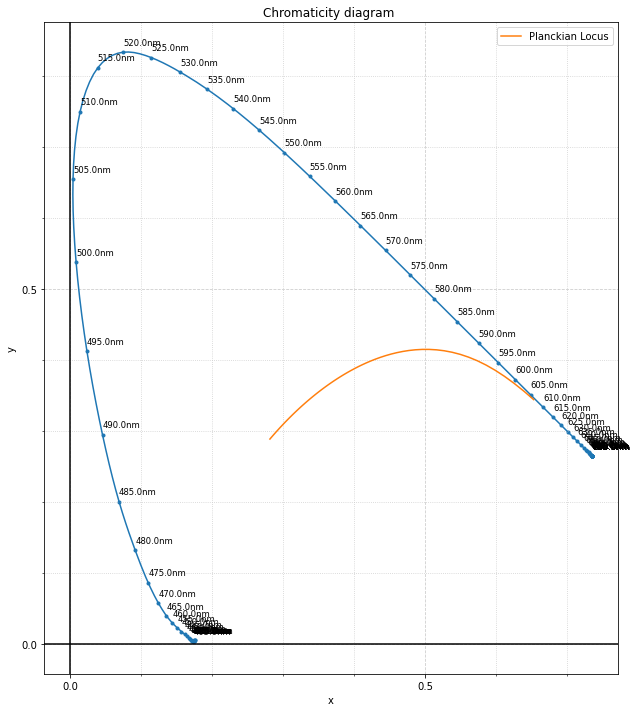

In [41]:
planckian_locus = []
for T in range(1000, 10000, 100):
    planckian_locus.append(black_body_radiator_xy(T))
planckian_locus = np.array(planckian_locus)

draw_spectral_locus(cie_nms, cie_xy_curve, show=False)
plt.plot(planckian_locus[:,0], planckian_locus[:,1], label='Planckian Locus')
plt.legend()
plt.show()

## 1.10. Het xy-diagram invullen met kleuren

We zullen nu de kleuren van de sRGB kleurenruimte invullen op het diagram, aangezien de figuren hier in de webbrowser ook in de sRGB kleurenruimte staan. Op die manier kleuren we het diagram in met de kleuren die het scherm waarop je werkt zou moeten kunnen weergeven.

Hiervoor zullen we voor elke xy-chromaticiteit in het vlak de overeenkomstige sRGB coëfficiënten berekenen. Indien de resulterende kleur in-gamut is, kunnen we het resultaat plotten. De stappen die je dus moet doorlopen zijn:
 1. Converteer xy naar XYZ
 2. Converteer XYZ naar sRGB
 3. Controleer in-gamut
 4. Pas sRGB gamma correctie toe (de exacte sRGB gamma; en dus niet de macht 2.2 benadering)

Als eerste opdracht moet je de `sRGB_to_CIEXYZ` matrix opzoeken, zodat:

$$\begin{bmatrix}X \\ Y \\ Z \end{bmatrix} = \text{sRGB_to_CIEXYZ} \begin{bmatrix}R_\text{linear} \\ G_\text{linear} \\ B_\text{linear} \end{bmatrix} $$

In [257]:
# YOUR CODE HERE
sRGB_to_CIEXYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                           [0.2126729, 0.7151522, 0.0721750],
                           [0.0193339, 0.1191920, 0.9503041]])

In [258]:
assert sRGB_to_CIEXYZ.shape == (3,3)
assert type(sRGB_to_CIEXYZ) is np.ndarray

Implementeer nu de sRGB gamma-correctie functie in `sRGB_gamma_correction`. Zorg er voor dat dit werkt voor numpy arrays (van arbitraire dimensionaliteit).

In [259]:
def sRGB_gamma_correction(u):
    return np.where(u <= 0.0031308, (323/25)*u, (211*(u**(5/12)) - 11)/200)

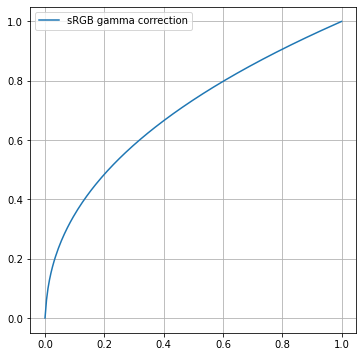

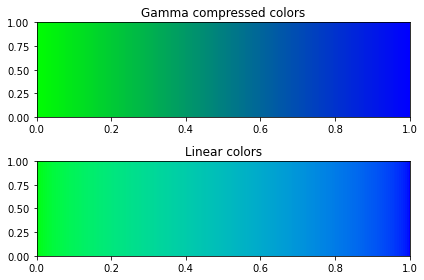

In [260]:
fig, ax = plt.subplots(figsize=(6,6))
xs = np.linspace(0.0, 1.0, 200)
ax.plot(xs, sRGB_gamma_correction(xs), label="sRGB gamma correction")
ax.legend()
ax.set_aspect("equal")
plt.grid()
plt.show()

fig, ax = plt.subplots(2, figsize=(6,4))
for x in xs:
    col = np.array([0.0, 1.0-x, x])
    ax[0].axvline(x, color=col, linewidth=5)
    ax[1].axvline(x, color=sRGB_gamma_correction(col), linewidth=2)
    
ax[0].set_title("Gamma compressed colors")
ax[1].set_title("Linear colors")
plt.tight_layout()
plt.grid()
plt.show()

In [261]:
# Should work for numpy arrays of all dimensions
assert sRGB_gamma_correction(0).shape == ()
assert sRGB_gamma_correction(np.zeros((5,))).shape == (5,)
assert sRGB_gamma_correction(np.zeros((5, 5,))).shape == (5, 5,)
assert sRGB_gamma_correction(np.zeros((5, 5, 5))).shape == (5, 5, 5)

In [262]:
# Actual function tests
assert np.isclose(sRGB_gamma_correction(0.0), 0.0)
assert np.isclose(sRGB_gamma_correction(1.0), 1.0)
assert np.isclose(sRGB_gamma_correction(0.010), 0.0998, atol=0.05)
assert np.isclose(sRGB_gamma_correction(0.214), 0.5, atol=0.001)

In [263]:
# Deze cell bevat verborgen tests (die je niet zal vinden in de source)!
# Laat ze dus staan, zodat de automatische verbetering werkt.

Hieronder implementeer je `produce_sRGB_xy_and_colors()`. Deze neemt als argument de luminantie `Y` (tussen 0 en 1), en returnt een Python 3-tuple `(sRGB_x, sRGB_y, sRGB_colors)`.
 - `sRGB_x` is een 1D numpy array met alle x-coördinaten van de in-gamut sRGB kleuren. Shape: (n,)
 - `sRGB_y` is een 1D numpy array met alle y-coördinaten van de in-gamut sRGB kleuren. Shape: (n,)
 - `sRGB_colors` is een 2D numpy array met alle sRGB kleurwaarden. Shape: (n, 3)
 
Let dus goed op de puntjes beschreven enkele cellen hogerop!

In [264]:
def produce_sRGB_xy_and_colors(Y, resolution=300):
    x_coords, y_coords = np.meshgrid(np.linspace(0.01, 1.0, resolution), np.linspace(0.01, 1.0, resolution))
    x = np.concatenate(x_coords)
    y = np.concatenate(y_coords)
    XYZ = np.array([(Y / y) * x, np.repeat(Y, len(y)), (Y / y) * (1 - x - y)])

    #print(XYZ)

    RGB = np.dot(np.linalg.inv(sRGB_to_CIEXYZ), XYZ)

    #print(RGB)
    #print(np.dot(np.linalg.inv(sRGB_to_CIEXYZ), XYZ[:, 0]))

    filter = np.logical_and(RGB.max(axis=0) <= 1.0, RGB.min(axis=0) >= 0.0)

    RGB = RGB[:, filter]
    RGB = np.apply_along_axis(sRGB_gamma_correction, 1, RGB)

    XYZ = np.dot(sRGB_to_CIEXYZ, RGB)

    x = XYZ[0]/(XYZ[0] +  XYZ[1] +  XYZ[2])
    y = XYZ[1]/(XYZ[0] +  XYZ[1] +  XYZ[2])

    return x, y, np.transpose(RGB)

In [265]:
for Y in [0.01, 0.1, 0.5, 1.0]:
    sRGB_x, sRGB_y, sRGB_col = produce_sRGB_xy_and_colors(Y)

    assert len(sRGB_x.shape) == 1
    assert len(sRGB_y.shape) == 1
    assert len(sRGB_col.shape) == 2
    assert sRGB_col.shape[1] == 3

    num_colors = sRGB_col.shape[0]
    assert len(sRGB_x) == num_colors
    assert len(sRGB_y) == num_colors
    print("Luminance Y = %.1f OK with %d in-gamut colors!" % (Y, num_colors))

Luminance Y = 0.0 OK with 10221 in-gamut colors!
Luminance Y = 0.1 OK with 10197 in-gamut colors!
Luminance Y = 0.5 OK with 5072 in-gamut colors!
Luminance Y = 1.0 OK with 0 in-gamut colors!


In [266]:
for Y in [0.0, 0.1, 0.5]:
    sRGB_x, sRGB_y, sRGB_col = produce_sRGB_xy_and_colors(Y)
    assert np.amin(sRGB_col) >= 0.0
    assert np.amax(sRGB_col) <= 1.0

C:\Users\renev\AppData\Local\Temp/ipykernel_28660/2151259278.py:21: RuntimeWarning: invalid value encountered in true_divide
  x = XYZ[0]/(XYZ[0] +  XYZ[1] +  XYZ[2])
C:\Users\renev\AppData\Local\Temp/ipykernel_28660/2151259278.py:22: RuntimeWarning: invalid value encountered in true_divide
  y = XYZ[1]/(XYZ[0] +  XYZ[1] +  XYZ[2])


In [267]:
# Deze cell bevat verborgen tests (die je niet zal vinden in de source)!
# Laat ze dus staan, zodat de automatische verbetering werkt.

In [268]:
# Deze cell bevat verborgen tests (die je niet zal vinden in de source)!
# Laat ze dus staan, zodat de automatische verbetering werkt.

In [269]:
# Deze cell bevat verborgen tests (die je niet zal vinden in de source)!
# Laat ze dus staan, zodat de automatische verbetering werkt.

Volgende code zal de sRGB kleuren plotten in het xy-chromaticiteitsdiagram met verschillende luminanties (0.07, 0.2, 0.5, 0.9). Dit kan je gebruiken als visuele controle.

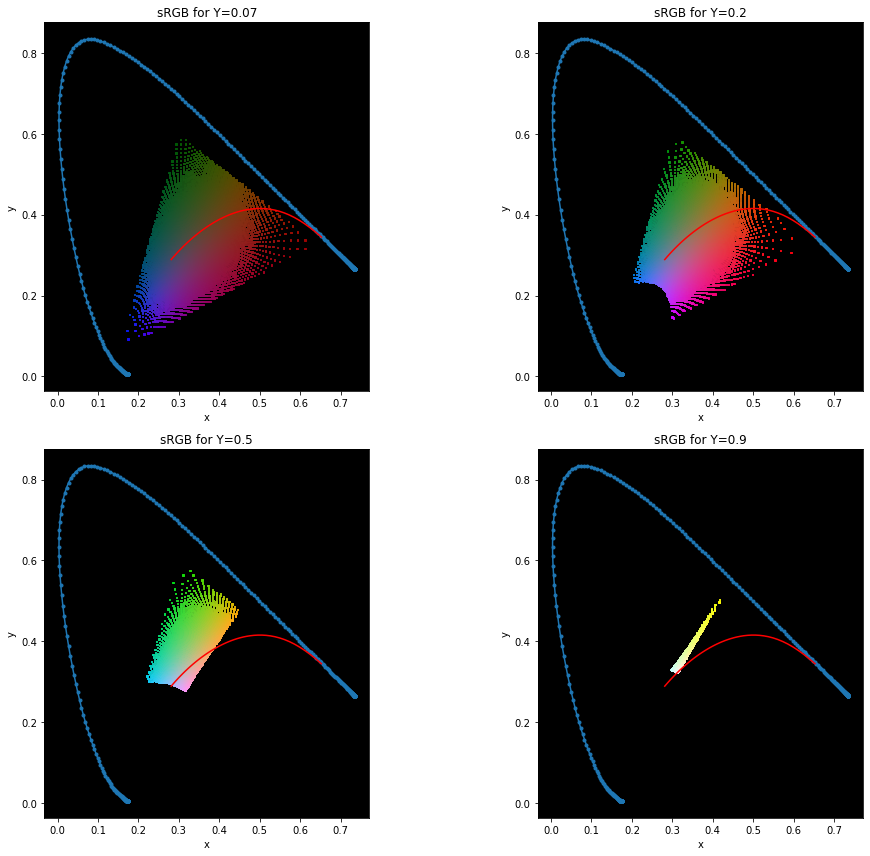

In [270]:
fig = plt.figure(figsize=(15,12))
for i, Y in enumerate([0.07, 0.2, 0.5, 0.9]):
    ax = fig.add_subplot(221 + i, facecolor='black')
    plt.plot(cie_xy_curve[0], cie_xy_curve[1])
    plt.scatter(cie_xy_curve[0], cie_xy_curve[1], s=9)

    sRGB_x, sRGB_y, sRGB_col = produce_sRGB_xy_and_colors(Y)
    plt.scatter(sRGB_x, sRGB_y, c=sRGB_col, s=1.8, marker='s')

    plt.plot(planckian_locus[:,0], planckian_locus[:,1], c='red')
    ax.set_aspect('equal')
    ax.set_title('sRGB for Y=' + str(Y))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()
plt.show()

## 1.11. Het 3D Gamut van xyY

Met behulp van de voorgaande functie `produce_sRGB_xy_and_colors` zullen we het volledige gamut van sRGB voorstellen in een point cloud met xyY als assenstelsel.

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = plt.axes(projection='3d', 
              facecolor='gray')
ax.set_proj_type('persp')
all_x = np.zeros((0,))
all_y = np.zeros((0,))
all_Y = np.zeros((0,))
all_col = np.zeros((0,3))

for Y in np.linspace(0.001, 1.0, 50):
    resolution = 60
    sRGB_x, sRGB_y, sRGB_col = produce_sRGB_xy_and_colors(Y, resolution=resolution)
    all_x = np.concatenate([all_x, sRGB_x], axis=0)
    all_y = np.concatenate([all_y, sRGB_y], axis=0)
    all_Y = np.concatenate([all_Y, np.ones_like(sRGB_y) * Y])
    all_col = np.concatenate([all_col, sRGB_col], axis=0)

ax.scatter3D(all_x, all_y, all_Y, c=all_col, marker='o');
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Y')
fig.tight_layout()

## 1.12. Regenboog

Nu we dit allemaal hebben kunnen we een benadering maken van hoe een regenboog er uit ziet. Een regenboog toont welke kleuren we te zien krijgen bij monochromatisch licht van elke golflengte. We willen de regenboog op ons scherm tonen. Hiervoor genereren we een afbeelding die met sRGB kleuren werkt. Dit is uiteraard een benadering omdat sRGB volledig bestaat uit niet-monochromatische kleuren, en elke kleur we willen tonen is monochromatisch. Elke kleur die we te zien krijgen is dus een beste benadering die wel binnen sRGB valt. Let op dat je hier het breken van licht door een prisma bij verschillende samenstellingen van lichtbron kan uitproberen: in de gecommentarieerde lijn hieronder kan je een illuminant kiezen door een temperatuur in te stellen en de wet van Planck te gebruiken.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,4))
sRGB_curves = np.linalg.inv(sRGB_to_CIEXYZ) @ cie_XYZ_curves
for ax, axis, title in zip(axes, [1, 0], ["Zero-Clipped", "Maximum luminance in sRGB"]):
    sRGB = np.maximum(sRGB_curves, 0.0)
    #sRGB *= black_body_radiator_spd(cie_nms, 6000)
    m = np.amax(sRGB, keepdims=True, axis=axis)
    sRGB /= m
    sRGB_gc = sRGB_gamma_correction(sRGB)
    for i, nm in enumerate(cie_nms):
        ax.axvline(nm, color=sRGB_gc[:,i], linewidth=3)
    ax.plot(cie_nms, np.transpose(sRGB_curves / m), color='gray', alpha=0.5)
    ax.set_title(title)
    ax.axhline(0.0, linewidth=1.0, color='k')
plt.tight_layout()
plt.show()

Let op hoe de sRGB amplitudes voor elke golflengte ook aangegeven staan. Je ziet duidelijk hoe een hele brede strook groen exact dezelfde kleur is in sRGB, doordat het R en B kanaal negatief zijn en er dus geen nuances mogelijk zijn binnen het groen. Wanneer we dit op een artificiële manier proberen compenseren door van alle sRGB coëfficiënten hun laagste (i.e.: meest negatieve) waarde af te trekken, zodat ze nooit onder 0 gaan, zien we meer nuances binnen de kleuren. Uiteraard is dit een ander manier om proberen kleuren weer te geven die eigenlijk niet weer te geven zijn, maar nu met meer nadruk op het duidelijk maken van de onderlinge verschillen, in plaats van voor elke niet-weer-te-geven kleur de dichtsbijzijnde kleur te kiezen. Bekijk onderstaande 3 grafieken die op 3 verschillende manieren de getallen positief maken.

In [ ]:
fig, axes = plt.subplots(3, figsize=(12,5), sharex=True)
for axis, ax in zip([None, 0, 1], axes):
    sRGB_curves = np.linalg.inv(sRGB_to_CIEXYZ) @ cie_XYZ_curves
    sRGB = sRGB_curves - np.amin(sRGB_curves, keepdims=True, axis=axis)
    sRGB /= np.amax(sRGB, keepdims=True, axis=1)
    sRGB_gc = sRGB_gamma_correction(sRGB)
    for i, nm in enumerate(cie_nms):
        ax.axvline(nm, color=sRGB_gc[:,i], linewidth=3)
    ax.plot(cie_nms, np.transpose(sRGB), color='w', alpha=0.5)
    ax.axhline(0.0, linewidth=1.0, color='k')
plt.tight_layout()
plt.show()

<hr/>

# 2. Een RAW bestand verwerken

In dit onderdeel zullen we alle nodige stappen doorlopen om de ruwe waarden van een digitale camera te verwerken om uiteindlijk weer te geven op het scherm, in de sRGB kleurenruimte.

Jullie krijgen een numpy-bestand (`*.npz`) ter beschikking met deze ruwe pixel-waarden in. Normaalgezien heeft elk camera model zijn eigen bestandsformaat. Nikon camera's gebruiken de bestandsnaamuitgang `.NEF`, bijvoorbeeld.

## 2.1. Het numpy-fotobestand inladen

In [ ]:
rawfile = np.load("lightbulb.npz")
data = rawfile['data']
CIEXYZ_to_RAW = rawfile['matrix']
camera_wb_coeff = rawfile['cam_mul']
print("Image resolution: " + str(data.shape))
print("Camera color matrix:\n" + str(CIEXYZ_to_RAW))
print("Camera white balance coefficients: " + str(camera_wb_coeff))

Zoals je kan zien bevat de file drie velden:

 - `data`: de ruwe camera waardes per pixel per kleur.
 - `matrix`: de <span style="color: red">conversie matrix van XYZ naar ruwe camera RGB kleuren</span>.
 - `cam_mul`: de <span style="color: red">gesuggereerde witbalans-coëfficiënten</span>.
 
Zoals je kan zien bevat de <span style="color: red">"shape"</span> van de `data` de dimensies van de foto: `(breedte, hoogte, kleurkanalen)`. Dergelijke multidimensionale arrays worden "**Tensoren**" genoemd, en is de generalisatie van het concept "matrix" naar meer dimensies. De terminologie gaat als volgt: scalair (0D), array (1D), matrix (2D), tensor (3D en hoger).
 
**Opmerking:** De numpy file die je hebt ingeladen bevat al 3 kleur-componenten per pixel. Een camera heeft echter één kleur-component per pixel (ofwel rood, ofwel groen, ofwel blauw). In deze numpy file zijn de kleuren reeds geïnterpoleerd, zodat er nu 3 kleuren per pixel aanwezig zijn.

## 2.2. De ruwe kleurwaarden bekijken
Hier maken we duidelijk wat het probleem is: de getallen van de kleuren uit de RAW file zijn helemaal niet geschikt om op je monitor weer te geven.

In [ ]:
dispim('unprocessed.jpg', data)

Hier is zowat alles mis: veel te donker en te groen-geel.

Voor we echt van start gaan, laten we even bekijken hoe de data er numeriek uit ziet:

In [ ]:
print("data size:", data.shape)
print("data type:", data.dtype)
print("data min:", np.amin(data))
print("data max:", np.amax(data))
print("max(uint16):", (2**16-1))

Gezien we met de kleuren zullen rekenen, zullen we de getallen normalizeren naar floats in de range 0 tot 1. De `dispim` functie werkt *ook* met dit formaat!

In [ ]:
data = data / np.amax(data)

def generate_RGB_histogram(data):
    fig, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True, sharey=True)
    for i in range(3):
        ax[i].grid(axis='x')
        ax[i].hist(data[:,:,i].reshape(-1), bins=200, log=True, color='rgb'[i], alpha=0.6)
        ax[i].set_ylabel("Aantal")
        ax[i].set_xlabel("Waarde " + 'RGB'[i])
        ax[i].axvline(0.0, c='k', linewidth=1)
        ax[i].axvline(1.0, c='k', linewidth=1)
    plt.suptitle("Histogram per kleurkanaal")
    plt.show()
    
generate_RGB_histogram(data)

## 2.3. Gamma correctie
Nog één poging voor we echt aan de slag gaan op de wetenschappelijk juiste manier: we weten dat we gamma-correctie moeten toepassen vooraleer we iets naar ons scherm sturen; en we weten dat de maximale waarde deze van 16 bit is. We normalizeren dus, en passen vervolgens gamma-correctie toe; en geef het resultaat weer met behulp van `dispim('gamma.jpg', ...)`. **Laat hierbij `data` ongewijzigd!!**

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Is data ongewijzigd gebleven?
assert np.isclose(np.mean(data, axis=(0, 1)), [0.04696084, 0.04157193, 0.01590007]).all()

Al een heel stuk beter, maar het blijft te groen. Dit komt uiteraard omdat de kleurenruimte van de camera niet sRGB is, maar iets anders. De webbrowser gebruikt wel sRGB om het resultaat mee te interpreteren, en stuurt het naar jouw scherm wat allicht (niet zeker dus) ook sRGB gebruikt. Vandaar de foute kleur. We vinden de specificatie van de kleurenruimte van de camera ook in de numpy-file (kijk naar `CIEXYZ_to_RAW`).

## 2.4. De kleurenruimte van de camera

Bepaal de xy-coördinaten van 3 primaire kleuren van de kleurenruimte van de camera. Noem deze: `RAW_r_xy`, `RAW_g_xy`, `RAW_b_xy`. Bepaal ook de xy-chromaticiteit van het witpunt van de camera. Noem deze: `RAW_w_xy`.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

print("RAW primaries:")
print("Red  :", RAW_r_xy)
print("Green:", RAW_g_xy)
print("Blue :", RAW_b_xy)
print("White:", RAW_w_xy)

In [ ]:
assert RAW_r_xy.shape == (2,)
assert RAW_g_xy.shape == (2,)
assert RAW_b_xy.shape == (2,)
assert RAW_w_xy.shape == (2,)

In [ ]:
fig = plt.figure(figsize=(8,11))
ax = fig.add_subplot(111, facecolor='black')
plt.plot(cie_xy_curve[0], cie_xy_curve[1])
plt.scatter(cie_xy_curve[0], cie_xy_curve[1], s=9)

sRGB_x, sRGB_y, sRGB_col = produce_sRGB_xy_and_colors(0.07)
plt.scatter(sRGB_x, sRGB_y, c=sRGB_col, s=4, marker='s')

plt.plot(planckian_locus[:,0], planckian_locus[:,1], c='red')
t = np.array([RAW_r_xy, RAW_g_xy, RAW_b_xy, RAW_r_xy])
plt.plot(t[:,0], t[:,1], c='y')
plt.scatter(RAW_w_xy[0], RAW_w_xy[1], c='y', marker='.')

ax.set_aspect('equal')
ax.set_title('Camera Color Space')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.axhline(y=0, color='w')
ax.axvline(x=0, color='w')
plt.tight_layout()
plt.show()

Verklaar aan de hand van het bovenstaande xy-diagram waarom de foto te groen was wanneer we deze onverwerkt probeerden weer te geven op ons scherm.

Welke van de onderstaande opties is de juiste:

 - **Optie A**: De groene punt van de camera-driehoek ligt veel dieper in het groen dan bij sRGB, waardoor de kleuren er te groen uit zagen wanneer we hier geen rekening mee houden.
 - **Optie B**: De gamma functie van de camera is zodanig verschillend dat het groene kleurkanaal te veel versterkt wordt.
 - **Optie C**: Het witpunt van sRGB ligt hoger op het diagram dan dat van de camera, waardoor de kleuren naar boven worden geduwd in het diagram wanneer we hier geen rekening mee houden.
 - **Optie D**: Doordat het groene hoekpunt van de camera buiten de zichtbare kleuren valt en de kleurwaarden eigenlijk negatief zijn, worden deze geclipt naar 0, wat dus te veel groen veroorzaakt.
 - **Optie E**: De blauwe en rode punt van de camera-driehoek liggen veel dieper in het rood en blauw dan bij sRGB, waardoor de kleuren richting de groene kant geduwd worden wanneer we hier geen rekening mee houden.
 - **Optie F**: Er is nog geen chromatic adaptation toegpast op de afbeelding. De kleuren moeten dus nog gecorrigeerd worden voor het omgevingslicht.

Stop de letter van jouw gekozen antwoord in de variabele `antwoord_groen` als Python string.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert type(antwoord_groen) is str
assert antwoord_groen in ["A", "B", "C", "D", "E", "F"]

Vul onderstaande functie `RAW_to_linear_sRGB` aan om de overgang van de RAW kleurenruimte naar **lineaire sRGB** juist uit te voeren, waarbij gebruik van for-loops verboden is (doe dus alles met numpy functies die de hele afbeelding in één keer verwerken). Als hint, zoek de documenatie op van:
 - `np.linalg.inv()`
 - `np.linalg.matmul()` of `@`
 
We voorzien reeds een hulpfunctie die een arbitraire hoeveelheid vectoren onafhankelijk vermenigvuldigt met een gegeven matrix. Deze kan je proberen begrijpen door ook de documentatie van volgende functies op te zoeken:
 - `np.expand_dims()` of numpy indexing met `np.newaxis`
 - `np.take()` of numpy indexing met Ellipsis (`...`)

**Zorg er voor dat je slechts één keer `matrix_vector_multiplication()` oproept op `colors`.** (Maak dus gebruik van associativiteit van de matrixvermenigvuldiging, om de hoeveelheid rekenwerk te optimaliseren).
Bekijk zeker ook de onderstaande tests om begrijpen wat de bedoeling is.

In [ ]:
def matrix_vector_multiplication(matrix, vectors):
    """ Multiplies every vector independently with the given (single) matrix. """
    return np.tensordot(vectors, matrix, axes=(-1,-1))


def RAW_to_linear_sRGB(colors):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert RAW_to_linear_sRGB(np.zeros((3,))).shape == (3,)
assert RAW_to_linear_sRGB(np.zeros((100, 3))).shape == (100, 3)
assert RAW_to_linear_sRGB(np.zeros((100, 100, 3))).shape == (100, 100, 3)

In [ ]:
# Black is (0,0,0) in every RGB color space:
assert np.isclose(RAW_to_linear_sRGB(np.array([0.0, 0.0, 0.0])), [0.0, 0.0, 0.0]).all()

# The gamut of the camera is bigger than sRGB:
assert np.amin(RAW_to_linear_sRGB(np.array([1.0, 0.0, 0.0]))) < 0.0
assert np.amin(RAW_to_linear_sRGB(np.array([0.0, 1.0, 0.0]))) < 0.0
assert np.amin(RAW_to_linear_sRGB(np.array([0.0, 0.0, 1.0]))) < 0.0

# The transform should be linear:
assert np.isclose(RAW_to_linear_sRGB(np.array([1.0, 1.0, 0.0])), 
                  RAW_to_linear_sRGB(np.array([1.0, 0.0, 0.0])) + 
                  RAW_to_linear_sRGB(np.array([0.0, 1.0, 0.0]))).all()
assert np.isclose(RAW_to_linear_sRGB(np.array([0.0, 1.0, 3.0])), 
                  RAW_to_linear_sRGB(np.array([0.0, 0.0, 2.0])) + 
                  RAW_to_linear_sRGB(np.array([0.0, 1.0, 1.0]))).all()

We kijken naar het histogram van de kleurwaarden per kleurkanaal voor de afbeelding na transformatie naar sRGB:

In [ ]:
generate_RGB_histogram(RAW_to_linear_sRGB(data))

Er zijn duidelijk enkele problemen met bovenstaand histogram: sommige waarden zijn kleiner dan 0, en een heleboel waarden groter dan 1. Wat de negatieve waarden betreft, deze zullen we gewoon op 0 zetten. Wat de te grote waarden betreft, zijn er twee voor de hand liggende opties. We noemen deze twee methoden `"herschalen"` (Engels: rescale) en `"afknippen"` (Engels: clip). Herschalen zal elk kleurkanaal van de afbeelding vermenigvuldigen met een zeker getal (één factor per afbeelding), zodat alle waarden kleiner of gelijk aan 1 worden. Clipping zal gewoon alles wat groter is dan 1 vervangen door 1. Welke van de deze twee opties zou je gebruiken in volgende scenario's?

**Scenario A**: Je verkiest maximale kleuraccuraatheid. Het is belangrijk verschillende tinten rood, groen, en oranje van elkaar te kunnen onderscheiden.

**Scenario B**: Je wenst de luminantie van elke pixel afzonderlijk zo gelijk mogelijk te houden. De kleurtint zelf maakt minder uit: zo goed als mogelijk is oké.

Vul hieronder aan welke van de twee technieken `"herschalen"` of `"afknippen"` je gebruikt voor scenario's A en B.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert type(techniek_scenario_A) is str
assert type(techniek_scenario_B) is str

Vul nu onderstaande functie `process_raw_1` in, zodat ze de input omrekent van RAW naar gamma-gecorrigeerde sRGB. Er mogen geen warnings of errors optreden. Vanaf hier gebruiken we de "afknippen" techniek.

In [ ]:
def process_raw_1(colors):
    # YOUR CODE HERE
    raise NotImplementedError()

dispim('process1.jpg', process_raw_1(data))

In [ ]:
# Should work on a single pixel, as well as on rows of pixels and images of pixels.
assert process_raw_1(np.zeros(3)).shape == (3,)
assert process_raw_1(np.zeros((10, 3))).shape == (10, 3)
assert process_raw_1(np.zeros((10, 10, 3))).shape == (10, 10, 3)

Al veel beter! Er zijn duidelijk nog twee problemen:
 1. de kleuren zijn nog te "warm", gezien de zaalverlichting heel "warm" was.
 2. het lampje heeft een eigenaardige kleur.

## 2.5. Chromatic Adaptation (Witbalans)
We zullen eerst chromatic adaptation uitvoeren om de "witbalans" te corrigeren voor de zaalverlichting; en er voor te zorgen dat witte voorwerpen (zoals het hemd) ook terug een witte kleur krijgt.

Hiervoor moeten we de foto eerst overbrengen naar het "adaptation domain", wat erg lijkt op de kleurenruimte van onze kegeltjes zelf. Je zou dus kunnen de Hunt-Pointer-Estevez transform gebruiken; maar verder onderzoek heeft aangetoond dat alternatieve adapation domains betere resultaten opleveren. De meest recente resultaten hierover vind je in de CIECAM02 standaard: "*CIE Color Appearance Model 2002*". Zoek de transformatiematrix van CIEXYZ naar het adapation domain zodat:
$$\begin{bmatrix} L\\M\\S \end{bmatrix}
  =
  \mathbf{M}_\mathrm{CAT02}
  \begin{bmatrix} X\\Y\\Z \end{bmatrix}$$
  
Noem deze matrix `CIECAT02`, waarbij "CAT" staat voor "Chromatic Adapation Transform". Kies opnieuw voor een variant die gebalanceerd is voor de equal-energy illuminant.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

print(CIECAT02)

In [ ]:
assert CIECAT02.shape == (3,3)
assert np.isclose(np.dot(CIECAT02, [1, 1, 1]), [1, 1, 1]).all()

Eens de kleuren uitgedrukt zijn in het adaptation domain, kan je de drie kleurkanalen herschalen (elk met een bepaalde factor). De factoren per kanaal worden bepaald door de "bron-illuminant" en de "doel-illuminant". De bron-illuminant is de kleur van de zaalverlichting, en de doel-illuminant is de kleur die je wenst te gebruiken als "wit".
De factoren zelf kan je uitrekenen door de verhouding van doel/bron te berekenen wanneer je deze ook uitdrukt in het adaptation domain.

Implementeer eerst de hulp-functie `xy_to_XYZ()` die xy-chromaticiteiten omrekent naar XYZ coördinaten, gegeven een luminantie Y.

In [ ]:
def xy_to_XYZ(xy, Y):
    # Wrap de argumenten in een numpy-array mocht dat nog niet het geval zijn.
    xy = np.array(xy)
    Y = np.array(Y)
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert xy_to_XYZ(np.array([1.0, 1.0]), 1.0).shape == (3,)

# Some simple math checks
assert np.isclose(
    xy_to_XYZ(np.array([0.33333, 0.33333]), 1.0),
    [1.0, 1.0, 1.0], atol=1e-4).all()

assert np.isclose(
    xy_to_XYZ(np.array([0.33333, 0.33333]), 0.2),
    [0.2, 0.2, 0.2], atol=1e-4).all()

assert np.isclose(
    xy_to_XYZ(np.array([0.0, 1.0]), 0.2),
    [0.0, 0.2, 0.0], atol=1e-4).all()

In [ ]:
# Does it also work on arbitrary shapes? Need help? Check numpy ellipsis indexing notation.
assert xy_to_XYZ(np.ones((2,)), 1.0).shape == (3,)
assert xy_to_XYZ(np.ones((10,2)), np.ones((10,))).shape == (10,3)
assert xy_to_XYZ(np.ones((10,10,2)), np.ones((10,10,))).shape == (10,10,3)

Stel dat de twee illuminanten gekend zijn (bron en doel) in hun xy-chromaticiteit; implementeer dan de functie `produce_adapation_matrix()` die de matrix berekent die je nodig hebt om een afbeelding die in XYZ staat te corrigeren (waarbij het resultaat opnieuw in XYZ staat). Maak hier nu gebruik van de hulpfunctie die je net geïmplementeerd hebt.

In [ ]:
def produce_adaptation_matrix(illum_src_xy, illum_dst_xy):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# It's a transformation matrix from XYZ to XYZ, so it should be 3x3.
assert produce_adaptation_matrix([1.0, 1.0], [1.0, 1.0]).shape == (3, 3)

# Equal src and dst illuminant should result in identity matrix.
assert np.isclose(
    produce_adaptation_matrix([1.0, 1.0], [1.0, 1.0]),
    np.eye(3)).all()

In [ ]:
# Functionality check
assert np.isclose(
    produce_adaptation_matrix([0.33, 0.30], [0.36, 0.38]),
    np.array([[ 1.00409707e+00, -6.43010045e-02, -7.52735321e-02],
              [-4.46166624e-02,  1.08511840e+00, -2.92216775e-02],
              [-7.36190599e-04, -7.05892773e-03,  5.61145349e-01]])
    , atol=1e-4).all()

### 2.4.1. Witbalans gokken

Als we naar de foto zelf kijken, zien we dus warm licht. Je zou kunnen veronderstellen dat dit licht afkomstig is van gloeilampen (Engels: *incandescent light bulbs*). Kies als Kelvin temperatuur voor de zaalverlichting 2900K, en kies 6504K als doel-illuminant (wat overeen komt met daglicht, en D65); en pas hiermee chromatic adapation toe. Maak dus gebruik van `black_body_radiator_xy()` en `produce_adapation_matrix()`. Vul onderstaande functie `process_raw_2()` aan; net als `process_raw_1()`, maar maak bouw nu de volledige transformatie matrix van RAW naar sRGB die meteen ook de chromatic adapation uitvoert. Gebruik die matrix om de afbeelding mee te transformeren door gebruik te maken van één `matrix_vector_multiplication()`.

**ROEP `process_raw_1()` DUS *NIET* AAN! HERIMPLEMENTEER DEZE FUNCTIE GEWOON OPNIEUW.**

In [ ]:
def process_raw_2(colors):
    # YOUR CODE HERE
    raise NotImplementedError()

dispim('process2.jpg', process_raw_2(data))

Al geen slecht resultaat; maar het hemd is misschien toch net iets te paars. Dit ligt aan de keuze van onze bron en doel illuminant. We hebben deze afgeschat en waren onderheving aan benaderingen (door NVIDIA XYZ curves, en de implementatie van de Wet van Planck). We kunnen namelijk beter doen, door de camera te laten helpen, en door de juiste chromaticiteit van daglicht te gebruiken.

### 2.4.2. Witbalans: De camera-suggestie gebruiken

De camera kan helpen hier omdat deze zelf ook een schatting maakt van de kleur van het omgevingslicht (dit is de "AUTO"-witbalans feature op een camera). De camera geeft ons deze informatie in de vorm van factoren in de kleurenruimte van de camera zelf. Deze vindt je terug in `camera_wb_coeff`.

In [ ]:
print(camera_wb_coeff)

Deze coëfficiënten zijn de factoren die de camera zou gebruiken om het omgevingslicht te "herschalen" naar D65 **in de kleurenruimte van de camera zelf**. Met andere woorden:

$$ \text{CIEXYZ_to_RAW} * \text{D65}_{XYZ} = (\text{CIEXYZ_to_RAW} * \text{omgevingslicht}_{XYZ}) \odot \text{camera_wb_coeff}$$

Hierbij staat $*$ voor de matrix-vector vermenigvuldiging; en $\odot$ staat voor de puntsgewijze vermenigvulding van de componenten van een vector.

Om chromatic adaptation toe te passen hebben we dus de XYZ coördinaat van de zaalverlichting nodig, zodat we deze kunnen gebruiken als bron-illuminant. Los de vergelijking op naar het omgevingslicht, en implementeer de oplossing in de cel hieronder door de variabele `camera_src_illum_XYZ` in te vullen. Als XYZ van D65 kies je de Y-component gelijk aan 1. Stop de XYZ-coördinaten van D65 in `D65_XYZ`, dewelke je opzoekt om de beste resultaten mogelijk te verkrijgen (met alle decimalen die je online vindt voor de 2° waarnemer).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

print("                  D65 (XYZ):", D65_XYZ)
print("         Manual guess (XYZ):", xy_to_XYZ(black_body_radiator_xy(2900), 1.0))
print("Camera guess srcIllum (XYZ):", camera_src_illum_XYZ)

In [ ]:
assert D65_XYZ.shape == (3,)
assert D65_XYZ[1] == 1.0

In [ ]:
assert camera_src_illum_XYZ.shape == (3,)

Implementeer nu hieronder `process_raw_3()` om de afbeelding opnieuw te verwerken net als in `process_raw_2()` maar gebruik dit keer de schatting van de camera en D65 als illuminanten om chromatic adaptation te doen.

**ROEP `process_raw_2()` DUS *NIET* AAN! HERIMPLEMENTEER DEZE FUNCTIE GEWOON OPNIEUW.**

In [ ]:
def process_raw_3(colors):
    # YOUR CODE HERE
    raise NotImplementedError()

dispim('process3.jpg', process_raw_3(data))

In [ ]:
assert np.isclose(
    process_raw_3(np.array([0.0, 0.0, 0.0])),
    [0.0, 0.0, 0.0]).all()

Opnieuw veel beter! Het laatste probleem is het lampje.

## 2.6. Het lampje

Op de plaats van het lampje kwam er **te veel licht op de sensor**. Dit betekent dat er meer licht was dan dat de sensor accuraat kan waarnemen, waardoor hij satureert. Satureren betekent dat de maximale waarde voor die pixels worden bereikt, hoewel de eigenlijke waarde een stuk groter had moeten zijn. De maximale waarde is hier dus (gezien de normalisatie van `data`) gelijk aan `1.0`.

Om het lampje dus te "corrigeren" zullen we moeten uitrekenen wat de corresponderende lineaire sRGB-coëfficiënten zijn, die overeenkomen met een gesatureerde sensor (gesatureerd in de 3 kleurkanalen). Deze resulterende getallen in lineaire sRGB is dus de "kleur" die de lamp krijgt, ten gevolge van het niet accuraat kunnen meten van de kleur tijdens het nemen van de foto. We weten dus dat deze kleur niet juist is, en wensen deze gewoon wit (in sRGB dus D65) te maken.

Er zijn vele technieken om hier mee om te gaan, maar hier kiezen we voor de meest simpele (en minst waardevolle) techniek. We zullen de afbeelding als het ware opnieuw fotograferen met een virtuele camera die nu D65 als witpunt (saturatiekleur) heeft. De echte camera had een paars-achtig witpunt, waardoor het lampje dus paars is. We zoeken dus de benodigde versterking van de afbeelding zodat de gesatureerde camera kleur nu opnieuw volledig satureert, maar dan in sRGB (met als witpunt D65).

Anders verwoord: het wit maken van die kleur doen we door de gehele afbeelding in luminantie te doen toenemen, zodat elke component van die kleur minstens 1 wordt, en we nadien alle kleurcoëfficiënten in de afbeelding groter dan 1 kunnen vervangen door (i.e.: "afknippen tot", "clippen tot") 1. Het vergroten van de luminantie doe je uiteraard door de kleuren van de gehele afbeelding gewoon uniform (i.e.: R, G, en B gelijk) te herschalen.

**Hint**: Maak eventueel gebruik van `generate_RGB_histogram()` in jouw functie als visuele hulp om tussenresultaten te inspecteren.

**Hint:** Ook deze herschalingsfactor kan je gewoon integreren in de transformatiematrix die zal toegepast worden op de gehele afbeelding, om op die manier nog steeds maar één matrix vermenigvuldiging te doen op de gehele afbeelding.

**Hint:** Gamma correctie is en blijft altijd de laatste stap.

**ROEP `process_raw_3()` DUS *NIET* AAN! HERIMPLEMENTEER DEZE FUNCTIE GEWOON OPNIEUW.**

In [ ]:
def process_raw_4(colors):
    # YOUR CODE HERE
    raise NotImplementedError()

dispim('process4.jpg', process_raw_4(data))

In [ ]:
assert np.isclose(
    process_raw_4(np.array([0.0, 0.0, 0.0])),
    [0.0, 0.0, 0.0]).all()

# A saturated sensor should map to sRGB white.
assert np.isclose(
    process_raw_4(np.array([1.0, 1.0, 1.0])),
    [1.0, 1.0, 1.0]).all()

# 3. Interactieve fotobewerker

Als laatste maken we een kleine variant op `raw_process_4()` die enkele parameters aanneemt en ook enkele effecten zal toepassen. We zullen volgende uitbreidingen maken:

 - De mogelijkheid om de luminantie van de foto aan te passen ("exposure"). De exposure waarde ("exposure value" of "EV") is <span style='color:red;'>exponentieel</span>: exposure=0 laat de afbeelding ongewijzigd; exposure=1 maakt de afbeelding dubbel zo helder.
 - De mogelijkheid om zelf de temperatuur van de zaalverlichting (bron illuminant) in te stellen aan de hand van een black-body radiator temperatuur in Kelvin; om daarmee de chromatic adaptation uit te voeren. Let dus goed op: je stelt de kleur van het omgevingslicht die weggefilterd moet worden in.
 - Reinhard tone mapping toepassen, gegeven de exposure-waarde. Zoek zelf op hoe dit werkt, maar maak gebruik van de maximale luminantie (die je berekent op basis van de meegegeven "exposure_value", en niet op basis van de afbeelding zelf). Je mag tonemapping uitvoeren op de RGB waarden zelf (component per component afzonderlijk), in plaats van op de luminantie. (Bekijk eventueel de syllabus) **Hint**: De Reinhard tone mapping functie past enkel de tone mapping toe, en niet de exposure stap zelf.

In [ ]:
def apply_exposure(data, EV):
    """
    Increases exposure by 'EV' stops.
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    
def apply_reinhard(data, EV):
    """
    Applies Reinhard tonemapping to the data.
    Data is assumed to be bound between 0 and 2**EV.
    """
    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
assert np.isclose(apply_exposure(0.0, 0.0), 0.0)
assert np.isclose(apply_exposure(4.0, 0.0), 4.0)
assert np.isclose(apply_exposure(0.0, 1.0), 0.0)
assert np.isclose(apply_exposure(1.0, 1.0), 2.0)
assert np.isclose(apply_exposure(1.0, -1.0), 0.5)

In [ ]:
assert np.isclose(apply_reinhard(0.0, 0.0), 0.0)
assert np.isclose(apply_reinhard(1.0, 0.0), 1.0)
assert np.isclose(apply_reinhard(0.0, 1.0), 0.0)
assert np.isclose(apply_reinhard(2.0, 1.0), 1.0)
assert np.isclose(apply_reinhard(0.0, 2.0), 0.0)
assert np.isclose(apply_reinhard(4.0, 2.0), 1.0)

assert np.isclose(apply_reinhard(0.0, -1.0), 0.0)
assert np.isclose(apply_reinhard(0.5, -1.0), 1.0)
assert np.isclose(apply_reinhard(0.0, -2.0), 0.0)
assert np.isclose(apply_reinhard(0.25, -2.0), 1.0)

Laat ons de Reinhard tonemapping functie bekijken voor verschillende EV waarden:

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
for EV in [-2.0, -1.0, 0.0, 1.0, 2.0]:
    x = np.linspace(0, 2**EV)
    ax.plot(x, apply_reinhard(x, EV), color=3*[0.0 + (EV + 2)* 0.15], label='EV: '+str(EV))
ax.set_aspect('equal')
ax.grid()
plt.title("Reinhard Response")
plt.xlabel("Input")
plt.ylabel("Output")
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
def process_raw_5(colors, exposure, temperature):
    # YOUR CODE HERE
    raise NotImplementedError()

Voer onderstaande cel uit om de interactieve fotobewerker aan te maken. Test wat verschillende waarden uit met de sliders en zorg er voor dat het resultaat er altijd goed uit ziet. Denk dus goed na over de volgorde van alle bewerkingen die je moet uitvoeren.

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def downsample(x):
    return (x[::2, ::2, :] + x[1::2, ::2, :] + x[::2, 1::2, :] + x[1::2, 1::2, :]) / 4
smalldata = downsample(downsample(data))

def photo_editor(exposure, temperature):
    dispim('tmp.jpg', process_raw_5(smalldata, exposure, temperature))

interactive_plot = interactive(photo_editor,
    exposure=widgets.FloatSlider(min=-5, max=10,value=0, step=0.05, continuous_update=False, layout=Layout(width='50%')),
    temperature=widgets.FloatSlider(min=2000, max=16000, value=6500, step=10, continuous_update=False, layout=Layout(width='75%')))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

<hr />

# Indienen

Controleer of jullie notebook volledig werkt, door bovenaan in de menu "Kernel" te klikken op "Restart Kernel & Run All". Als alles werkt en er goed uit ziet; kies dan uit de menu "Cell" -> "All Output" -> **"Clear"**. Dit verwijdert alle uitvoer van de Notebook. **Sla** jullie Notebook zo **op** en dien deze versie in op Ufora (enkel de `.ipynb` file (geen .zip, geen .csv)! Hernoem de file niet!).